In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yiguyf","key":"17b73b0d6794285b18cf3ca31fc8e205"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                               29MB  2023-11-16 01:38:36           2191        206  1.0              
muhammadbinimran/housing-price-prediction-data              Housing Price Prediction Data                       763KB  2023-11-21 17:56:32          10125        171  1.0              
thedevastator/netflix-imdb-scores                           Netflix IMDB Scores                                 699KB  2023-12-03 14:10:34           4232         75  1.0              
thedrcat/daigt-proper-train-dataset                         DAIGT Proper Train D

In [ ]:
!kaggle datasets download -d jrobischon/wikipedia-movie-plots

 57% 17.0M/29.9M [00:00<00:00, 44.4MB/s]
100% 29.9M/29.9M [00:00<00:00, 74.0MB/s]


In [ ]:
!mkdir train
!unzip wikipedia-movie-plots.zip -d train

Archive:  wikipedia-movie-plots.zip
  inflating: train/wiki_movie_plots_deduped.csv  


##Loading dataset

In [1]:
import pandas as pd
df=pd.read_csv(r'/content/wiki_movie_plots_deduped.csv',encoding='utf-8')
print(df.head())
print(df.info(),df.columns)


   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.

## Data preprocessing and Feature selection

In [2]:
import gc # garbage collector
data= df[['Title','Plot']]
del df
gc.collect()

0

In [3]:
data.dropna(inplace=True)
data.drop_duplicates(subset=['Plot'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33869 entries, 0 to 34885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   33869 non-null  object
 1   Plot    33869 non-null  object
dtypes: object(2)
memory usage: 793.8+ KB


##visualizing the distribution of text lengths in the 'Plot' column of the DataFrame

<ipython-input-4-df89f01db0cf>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')


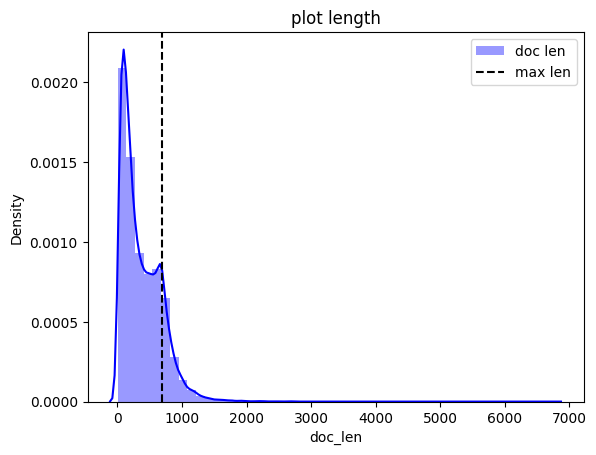

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data['doc_len'] = data['Plot'].apply(lambda words: len(words.split()))#counting each words
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)#calculating the maximum sequence length
sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

# <b>sentence embedding using Universal Sentence Encoder ->

##Importing required libraries

In [5]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [6]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [7]:
# # Reduce logging output.
logging.set_verbosity(logging.ERROR)

# message_embeddings = embed(messages)
def embed_in_batches(messages, batch_size=100):
    embeddings = []
    for i in range(0, len(messages), batch_size):
        batch_messages = messages[i:i+batch_size]
        batch_embeddings = embed(batch_messages)
        embeddings.extend(batch_embeddings)
    return embeddings


batch_size = 100

messages = data['Plot']
logging.set_verbosity(logging.ERROR)
# Embed messages in batches
message_embeddings = embed_in_batches(messages, batch_size)



#Semantic Textual Similarity

In [26]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

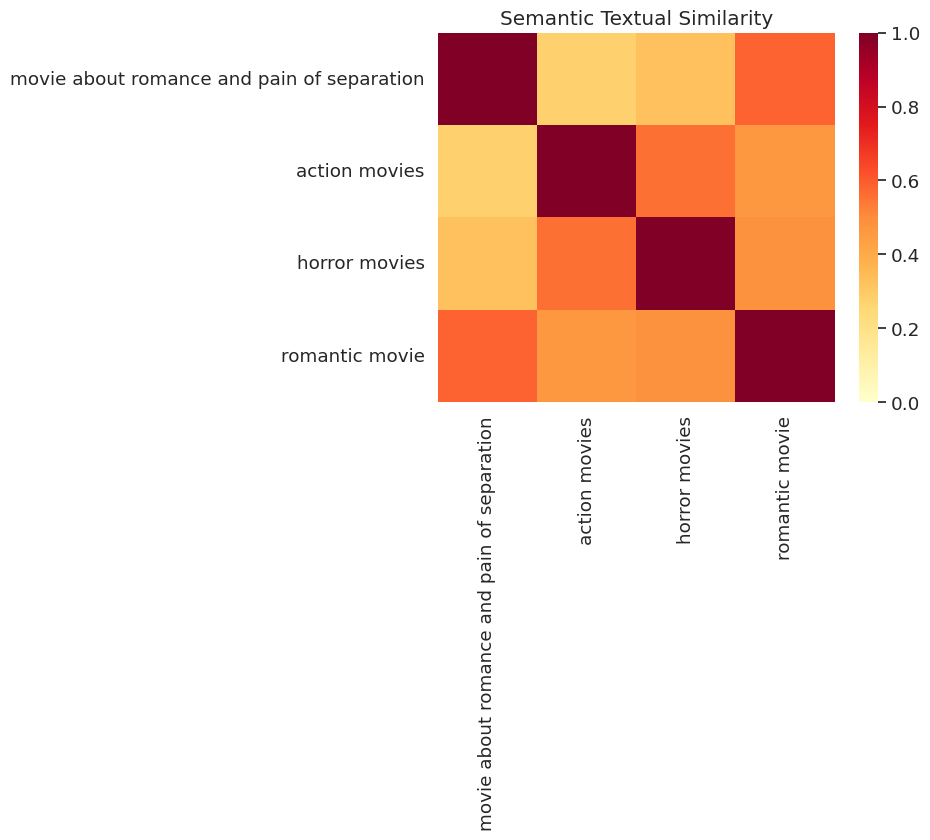

In [27]:
messages = [

    "movie about romance and pain of separation",
    "action movies",
    "horror movies",
    "romantic movie",
]

run_and_plot(messages)

##<b>Faiss implementation

In [9]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.1 MB/s eta 0:00:00


In [23]:
import faiss
index_dimension=512
index = faiss.IndexFlatL2(512)
numpy_embedding = np.array(message_embeddings)
index.add(numpy_embedding)

# Save the Faiss index to a file
faiss.write_index(index, "faiss_index_file_USE.index")

In [24]:
import time
def fetch_movie_info(dataframe_idx):
    info = data.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict

def search(query, top_k, index, model):
    t=time.time()
    query_vector = embed([query])
    top_k = index.search(np.array(query_vector), top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [25]:
from pprint import pprint

query="Romantic movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.03570270538330078


	 {'Title': 'Tere Pyar Mein'}
	 {'Title': 'Lal Dupatta Malmal Ka'}
	 {'Title': 'Thavarina Runa'}
	 {'Title': 'Manasina Maathu'}
	 {'Title': 'Premsutra'}


###<b>-----------------------------------------------------------------------------------------------------------------------------</b>
#<b>            Semantic search using sbert and faiss

##<b>--------------------------------------------------------------------------------

In [28]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=220b718004c2e75f785d4cbb24138ffee016018977d9d5c4de4aff5fce9f54d5
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33869 entries, 0 to 34885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    33869 non-null  object
 1   Plot     33869 non-null  object
 2   doc_len  33869 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


##Importing important libraries and loading distilbert model

In [30]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

##Importing Faiss and saving sbert embedding

In [32]:
import faiss
encoded_data = model.encode(data.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))
faiss.write_index(index, 'movie_plot_sbert.index')

In [34]:
def fetch_movie_info(dataframe_idx):
    info = data.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict

def sbert_search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [36]:
from pprint import pprint

query="Romantic movie"
results=sbert_search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.06996035575866699


	 {'Title': 'Tere Pyar Mein'}
	 {'Title': 'Lal Dupatta Malmal Ka'}
	 {'Title': 'Manasina Maathu'}
	 {'Title': 'Kalgejje'}
	 {'Title': 'Rose Guitarinaal'}
